# Movies Short Story 

this data set contain more than 45k short story

# Unzip The dataset

In [1]:
!unzip /content/Arabic_poetry_dataset.csv.zip

Archive:  /content/Arabic_poetry_dataset.csv.zip
  inflating: Arabic_poetry_dataset.csv  
  inflating: __MACOSX/._Arabic_poetry_dataset.csv  


In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
dataset = pd.read_csv('/content/Arabic_poetry_dataset.csv')
dataset.head(5)

,id,category,poet_name,poem_title,poem_text
0,0,الإمارات,خلفان بن مصبح,بدت تختال في حُلل الجمالِ,بدت تختال في حُلل الجمالِ\nوجادت بالزيارة والو...
1,1,الإمارات,خلفان بن مصبح,يا طائر الشعر القرير,يا طائر الشعر القرير\nيا وحي إلهام الصدور\nأسع...
2,2,الإمارات,خلفان بن مصبح,بنت حجرات أرى من عجب,بنت حجرات أرى من عجب\nأن أرى فيك جمال العرب\nد...
3,3,الإمارات,خلفان بن مصبح,هذا الربيع بنور الحسن وافانا,هذا الربيع بنور الحسن وافانا\nوقد كسا الأرض با...
4,4,الإمارات,خلفان بن مصبح,روحي فداك وإن مُنحتُ صدوداً,روحي فداك وإن مُنحتُ صدوداً\nأخفاك ما بي أم أط...


#### take 200 stories

In [8]:
poems_count = 200
generated_poet = dataset[dataset['poet_name'] == 'جبران خليل جبران'].sample(frac=1)[:poems_count]
poems = np.array(generated_poet['poem_text'].values.tolist())

#### clean the text

In [9]:
clean_poets = []
for i in poems:
    clean_poets.append(re.sub('([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+', ' ', i))

# Build The Tokenizer

In [10]:
tokenizer = Tokenizer()
corpus = clean_poets

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)

5298


### make n-grams for the text

In [12]:
sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        sequences.append(n_gram_sequence)

In [13]:
pad_seq = [len(x) for x in sequences]
max_sequence_len = max(pad_seq)
print(max_sequence_len)

496


In [40]:
pad_seq = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
poets_input, poets_pred = pad_seq[:,:-1],pad_seq[:,-1]

poets_pred = tf.keras.utils.to_categorical(poets_pred, num_classes=total_words)

In [41]:
poets_input.shape

(8224, 495)

# Build The Model

In [46]:
class GeneratePoemModel(tf.keras.Model):
  def __init__(self,input_length,output_length,max_length):
    super(GeneratePoemModel,self).__init__()
    self.input_length = input_length
    self.output_length = output_length
    self.max_length = max_length
    
    # processing layer
    self.embd = tf.keras.layers.Embedding(self.input_length,self.output_length,input_length=self.max_length-1)
    self.bid1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True))
    self.bid2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))
    self.bid3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
    self.drops = tf.keras.layers.Dropout(0.2)
    self.btch = tf.keras.layers.BatchNormalization()
        
    # output layer
    self.outs = tf.keras.layers.Dense(self.input_length,activation=tf.nn.softmax)

  def build(self):
    # input layer
    input = tf.keras.Input(shape=(max_sequence_len-1))
    x = self.embd(input)
    x = self.bid1(x)
    x = self.bid2(x)
    x = self.bid3(x)
    x = self.btch(x)
    x = self.drops(x)
    out = self.outs(x)
    return tf.keras.Model(input,out)

In [47]:
vocabs_size = 100
model = GeneratePoemModel(total_words,vocabs_size,max_sequence_len)
model = model.build()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 495)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 495, 100)          529800    
                                                                 
 bidirectional_21 (Bidirecti  (None, 495, 512)         731136    
 onal)                                                           
                                                                 
 bidirectional_22 (Bidirecti  (None, 495, 256)         656384    
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                           

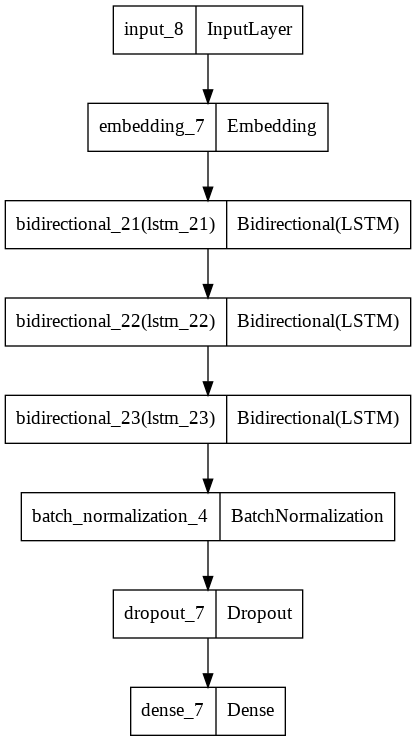

In [48]:
tf.keras.utils.plot_model(model)

In [49]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
history = model.fit(poets_input, poets_pred, epochs=20, verbose=1,batch_size=128, shuffle=True)

Epoch 1/20
65/65 [==============================] - 35s 312ms/step - loss: 8.5709 - accuracy: 0.0079
Epoch 2/20
65/65 [==============================] - 21s 317ms/step - loss: 8.3229 - accuracy: 0.0261
Epoch 3/20
65/65 [==============================] - 20s 307ms/step - loss: 7.8038 - accuracy: 0.0439
Epoch 4/20
65/65 [==============================] - 20s 312ms/step - loss: 7.3279 - accuracy: 0.0579
Epoch 5/20
65/65 [==============================] - 20s 302ms/step - loss: 6.8725 - accuracy: 0.0734
Epoch 6/20
65/65 [==============================] - 20s 303ms/step - loss: 6.3785 - accuracy: 0.0875
Epoch 7/20
65/65 [==============================] - 20s 313ms/step - loss: 5.8630 - accuracy: 0.1119
Epoch 8/20
65/65 [==============================] - 20s 304ms/step - loss: 5.3132 - accuracy: 0.1374
Epoch 9/20
65/65 [==============================] - 20s 306ms/step - loss: 4.7477 - accuracy: 0.1794
Epoch 10/20
65/65 [==============================] - 20s 303ms/step - loss: 4.1885 - accura

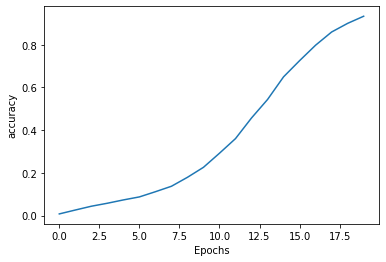

In [51]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [62]:
model.save('generate_poets_model.h5')